## Семинар 7: "Методы оптимизации"

ФИО: Елохов Артур Владимирович

In [67]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
from torch import nn

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [8]:
def GD(f, df, start_point, learning_rate=0.01, max_iter=1000, eps=1e-5, is_trace=False):
    cur_iter = 1
    cur_point = np.array(start_point)
    trace = []
    while(True):
        trace.append(cur_point)
        prev_point = cur_point
        cur_point = cur_point - learning_rate * df(cur_point)
        cur_iter += 1
        if(cur_iter == max_iter or np.linalg.norm(df(cur_point)) < eps):
            break
    trace.append(cur_point)
    if(is_trace):
        return np.array(trace)
    else:
        return cur_point

In [9]:
def Momentum(f, df, start_point, gamma=0.9, learning_rate=0.01, max_iter=1000, eps=1e-5, is_trace=False):
    cur_iter = 1
    cur_point = np.array(start_point)
    trace = []
    prev_velocity = np.array([0.0, 0.0])
    while(True):
        trace.append(cur_point)
        prev_point = cur_point
        cur_velocity = gamma*prev_velocity + learning_rate*df(cur_point)
        cur_point = cur_point - cur_velocity
        cur_iter += 1
        if(cur_iter == max_iter or np.linalg.norm(df(cur_point)) < eps):
            break
    trace.append(cur_point)
    if(is_trace):
        return np.array(trace)
    else:
        return cur_point

In [10]:
def NAG(f, df, start_point, gamma=0.9, learning_rate=0.01, max_iter=1000, eps=1e-5, is_trace=False):
    cur_iter = 1
    cur_point = np.array(start_point)
    trace = []
    prev_velocity = np.array([0.0, 0.0])
    while(True):
        trace.append(cur_point)
        prev_point = cur_point
        cur_velocity = gamma*prev_velocity
        cur_velocity += learning_rate*df(cur_point - cur_velocity)
        cur_point = cur_point - cur_velocity
        cur_iter += 1
        if(cur_iter == max_iter or np.linalg.norm(df(cur_point)) < eps):
            break
    trace.append(cur_point)
    if(is_trace):
        return np.array(trace)
    else:
        return cur_point

In [11]:
def Adagrad(f, df, start_point, learning_rate=0.01, max_iter=1000, eps=1e-5, is_trace=False):
    cur_iter = 1
    cur_point = np.array(start_point)
    trace = []
    Gradsum = np.array([0.0, 0.0])
    rooteps = 1e-8
    while(True):
        trace.append(cur_point)
        prev_point = cur_point
        Gradsum += df(cur_point)**2
        cur_point = cur_point - learning_rate/np.sqrt(Gradsum + rooteps) * df(cur_point)
        cur_iter += 1
        if(cur_iter == max_iter or np.linalg.norm(df(cur_point)) < eps):
            break
    trace.append(cur_point)
    if(is_trace):
        return np.array(trace)
    else:
        return cur_point

In [12]:
def Adadelta(f, df, start_point, gamma=0.9, max_iter=1000, eps=1e-5, is_trace=False):
    cur_iter = 1
    cur_point = np.array(start_point)
    trace = []
    mean_sq_grad = np.array([0.0, 0.0])
    mean_sq_step = np.array([0.0, 0.0])
    rooteps = 1e-8
    while(True):
        trace.append(cur_point)
        prev_point = cur_point
        mean_sq_grad = gamma*mean_sq_grad + (1 - gamma)*df(cur_point)**2
        RMSg = np.sqrt(mean_sq_grad + rooteps)
        RMSstep = np.sqrt(mean_sq_step + rooteps)
        step = RMSstep/RMSg*df(cur_point)
        cur_point = cur_point - step
        mean_sq_step = gamma*mean_sq_step + (1 - gamma)*step**2
        cur_iter += 1
        if(cur_iter == max_iter or np.linalg.norm(df(cur_point)) < eps):
            break
    trace.append(cur_point)
    if(is_trace):
        return np.array(trace)
    else:
        return cur_point

In [13]:
def Adam(f, df, start_point, beta1=0.9, beta2=0.999, learning_rate=0.01, max_iter=1000, eps=1e-5, is_trace=False):
    cur_iter = 1
    cur_point = np.array(start_point)
    trace = []
    rooteps = 1e-8
    mean_grad = np.array([0.0, 0.0])
    mean_sq_grad = np.array([0.0, 0.0])
    while(True):
        trace.append(cur_point)
        prev_point = cur_point
        mean_grad = beta1*mean_grad + (1.0 - beta1)*df(cur_point)
        mean_sq_grad = beta2*mean_sq_grad + (1.0 - beta2)*df(cur_point)**2
        mean_grad = mean_grad/(1.0 - beta1**cur_iter)
        mean_sq_grad = mean_sq_grad/(1.0 - beta2**cur_iter)
        cur_point = cur_point - learning_rate/np.sqrt(mean_sq_grad + rooteps) * mean_grad
        cur_iter += 1
        if(cur_iter == max_iter or np.linalg.norm(df(cur_point)) < eps):
            break
    trace.append(cur_point)
    if(is_trace):
        return np.array(trace)
    else:
        return cur_point

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [14]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])
start_point = tuple(np.random.rand(2,1).reshape(2) * 20 - 10)

In [15]:
def apply_grads(f, df, start_point, Traces):
    Names = ["GD", "Momentum", "NAG", "Adagrad", "Adadelta", "Adam"]
    print "start point: (%f, %f)" %(start_point[0], start_point[1])
    for i in xrange(len(Traces)):
        opt_point = Traces[i][-1:].reshape(2)
        opt_val = f(opt_point)
        print("%s\nIterations: %d\nExtremum point: (%f, %f)\nOptimal function value: %f" 
              %(Names[i], len(Traces[i]), opt_point[0], opt_point[1], opt_val))
    x = np.linspace(-10, 10, 101)
    y = np.linspace(-10, 10, 101)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in xrange(X.shape[0]):
        for j in xrange(Y.shape[0]):
            Z[i,j] = f((X[i,j], Y[i,j]))
    plt.figure(figsize=(16,20))
    for i in xrange(len(Traces)):
        trace = Traces[i]
        plt.subplot(3, 2, i+1)
        CS = plt.contour(X, Y, Z)
        plt.clabel(CS, inline=1, fontsize=10)
        plt.plot(trace[:, 0], trace[:, 1], linewidth=2.0, c='b')
        plt.title(Names[i])
    plt.show()
    return

In [25]:
Traces = [GD(f, df, start_point, is_trace=True),
          Momentum(f, df, start_point, is_trace=True),
          NAG(f, df, start_point, is_trace=True),
          Adagrad(f, df, start_point, learning_rate=1.0, is_trace=True),
          Adadelta(f, df, start_point, gamma=0.3, max_iter=10000, is_trace=True),
          Adam(f, df, start_point, beta1=0.5, beta2=0.5, max_iter=10000, is_trace=True)]

start point: (-1.647692, 9.850456)
GD
Iterations: 720
Extremum point: (-0.000001, 0.000005)
Optimal function value: 0.000000
Momentum
Iterations: 720
Extremum point: (-0.000001, 0.000005)
Optimal function value: 0.000000
NAG
Iterations: 720
Extremum point: (-0.000001, 0.000005)
Optimal function value: 0.000000
Adagrad
Iterations: 429
Extremum point: (-0.000000, 0.000005)
Optimal function value: 0.000000
Adadelta
Iterations: 3666
Extremum point: (-0.000000, -0.000001)
Optimal function value: 0.000000
Adam
Iterations: 10000
Extremum point: (-0.003276, -0.002048)
Optimal function value: 0.000015


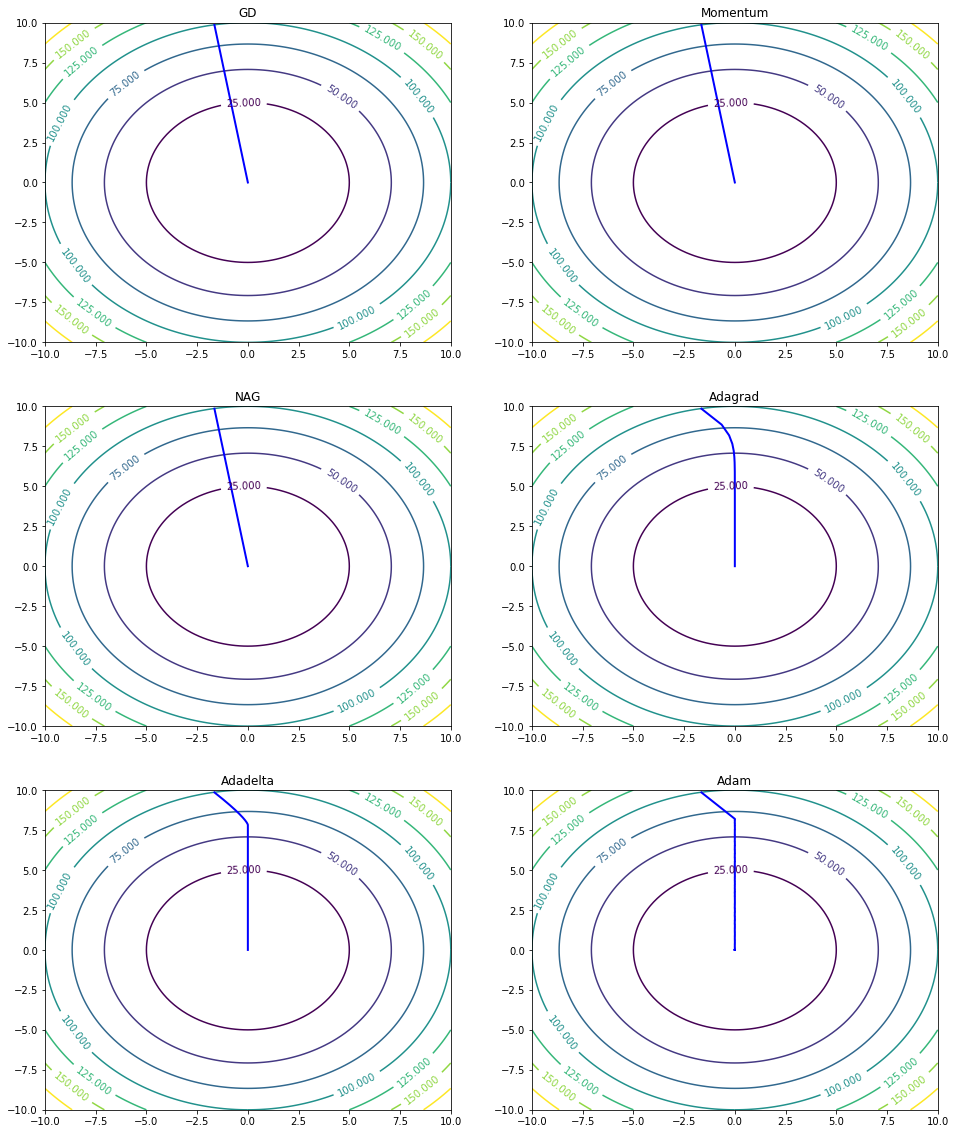

In [26]:
apply_grads(f, df, start_point, Traces)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [27]:
f = lambda X: np.sin(X[0])*X[0]**2+np.sin(X[1])*X[1]**2
df = lambda X: np.array([2*X[0]*np.sin(X[0]) + np.cos(X[0])*X[0]**2, 2*X[1]*np.sin(X[1]) + np.cos(X[1])*X[1]**2])
start_point = tuple(np.random.rand(2,1).reshape(2) * 20 - 10)

In [28]:
Traces = [GD(f, df, start_point, learning_rate=0.01, max_iter=10000, is_trace=True),
          Momentum(f, df, start_point, learning_rate=0.01, max_iter=10000, is_trace=True),
          NAG(f, df, start_point, learning_rate=0.01, max_iter=10000, is_trace=True),
          Adagrad(f, df, start_point, learning_rate=1.0, is_trace=True),
          Adadelta(f, df, start_point, gamma=0.1, max_iter=1000, is_trace=True),
          Adam(f, df, start_point, beta1=0.7, beta2=0.7, learning_rate=0.1, max_iter=50, is_trace=True)]

start point: (2.887680, 4.793469)
GD
Iterations: 56
Extremum point: (5.086985, 5.086985)
Optimal function value: -48.165920
Momentum
Iterations: 56
Extremum point: (5.086985, 5.086985)
Optimal function value: -48.165920
NAG
Iterations: 56
Extremum point: (5.086985, 5.086985)
Optimal function value: -48.165920
Adagrad
Iterations: 24
Extremum point: (5.086985, 5.086985)
Optimal function value: -48.165920
Adadelta
Iterations: 1000
Extremum point: (4.924629, 5.085648)
Optimal function value: -47.790728
Adam
Iterations: 50
Extremum point: (5.097167, 5.097854)
Optimal function value: -48.162622


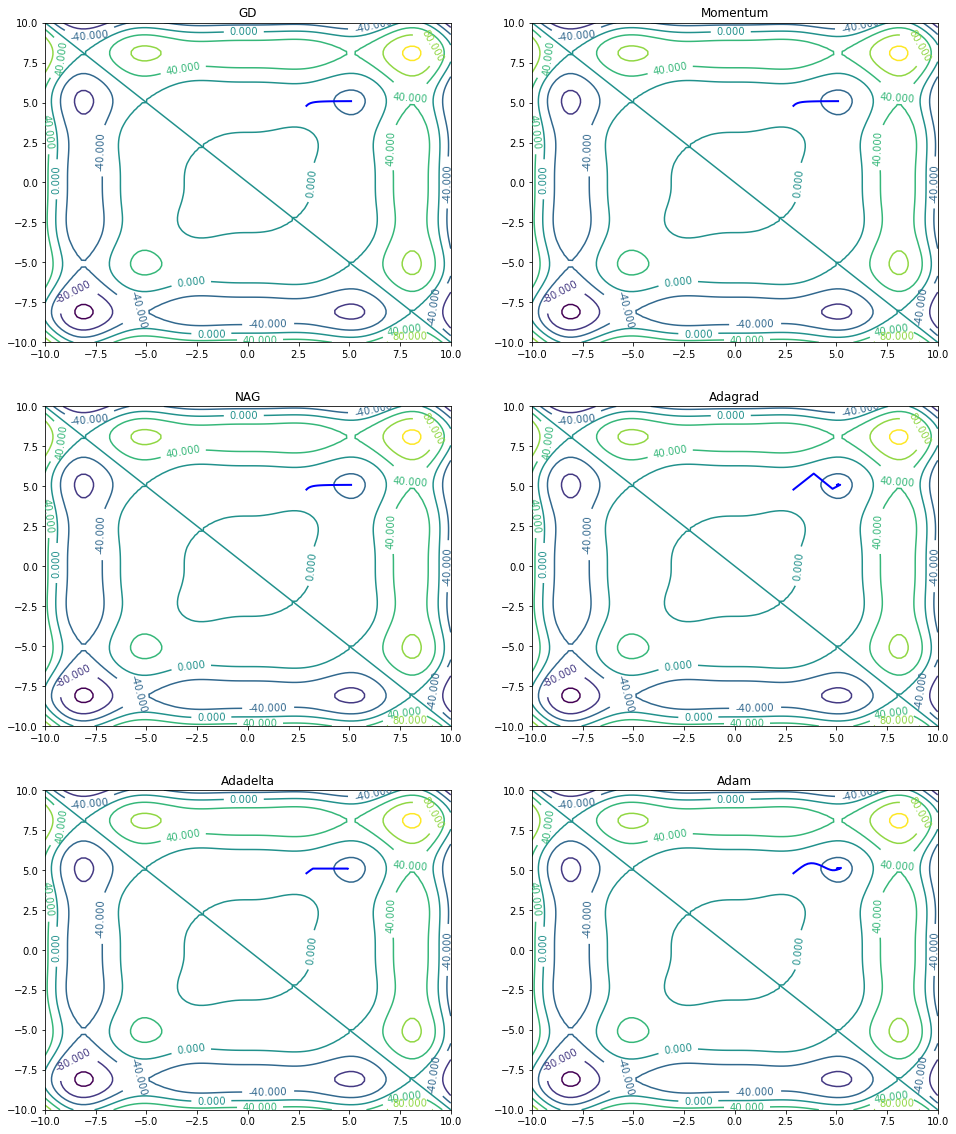

In [29]:
apply_grads(f, df, start_point, Traces)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [30]:
f = lambda X: np.sin(X[0]**2)*X[0]**2+np.sin(X[1]**2)*X[1]**2
df = lambda X: np.array([2*X[0]*np.sin(X[0]**2) + 2*X[0]*np.cos(X[0]**2)*X[0]**2,
                         2*X[1]*np.sin(X[1]**2) + 2*X[1]*np.cos(X[1]**2)*X[1]**2])
start_point = tuple(np.random.rand(2,1).reshape(2) * 20 - 10)

In [31]:
Traces = [GD(f, df, start_point, learning_rate=0.001, is_trace=True),
          Momentum(f, df, start_point, learning_rate=0.001, is_trace=True),
          NAG(f, df, start_point, learning_rate=0.001, is_trace=True),
          Adagrad(f, df, start_point, learning_rate=0.1, is_trace=True),
          Adadelta(f, df, start_point, gamma=0.1, max_iter=1000, is_trace=True),
          Adam(f, df, start_point, beta1=0.7, beta2=0.7, max_iter=100, is_trace=True)]

start point: (-1.994613, -1.600783)
GD
Iterations: 181
Extremum point: (-2.216570, -2.216569)
Optimal function value: -9.628940
Momentum
Iterations: 181
Extremum point: (-2.216570, -2.216569)
Optimal function value: -9.628940
NAG
Iterations: 181
Extremum point: (-2.216570, -2.216569)
Optimal function value: -9.628940
Adagrad
Iterations: 52
Extremum point: (-2.216570, -2.216569)
Optimal function value: -9.628940
Adadelta
Iterations: 1000
Extremum point: (-2.215167, -2.217782)
Optimal function value: -9.628764
Adam
Iterations: 100
Extremum point: (-2.215400, -2.215266)
Optimal function value: -9.628783


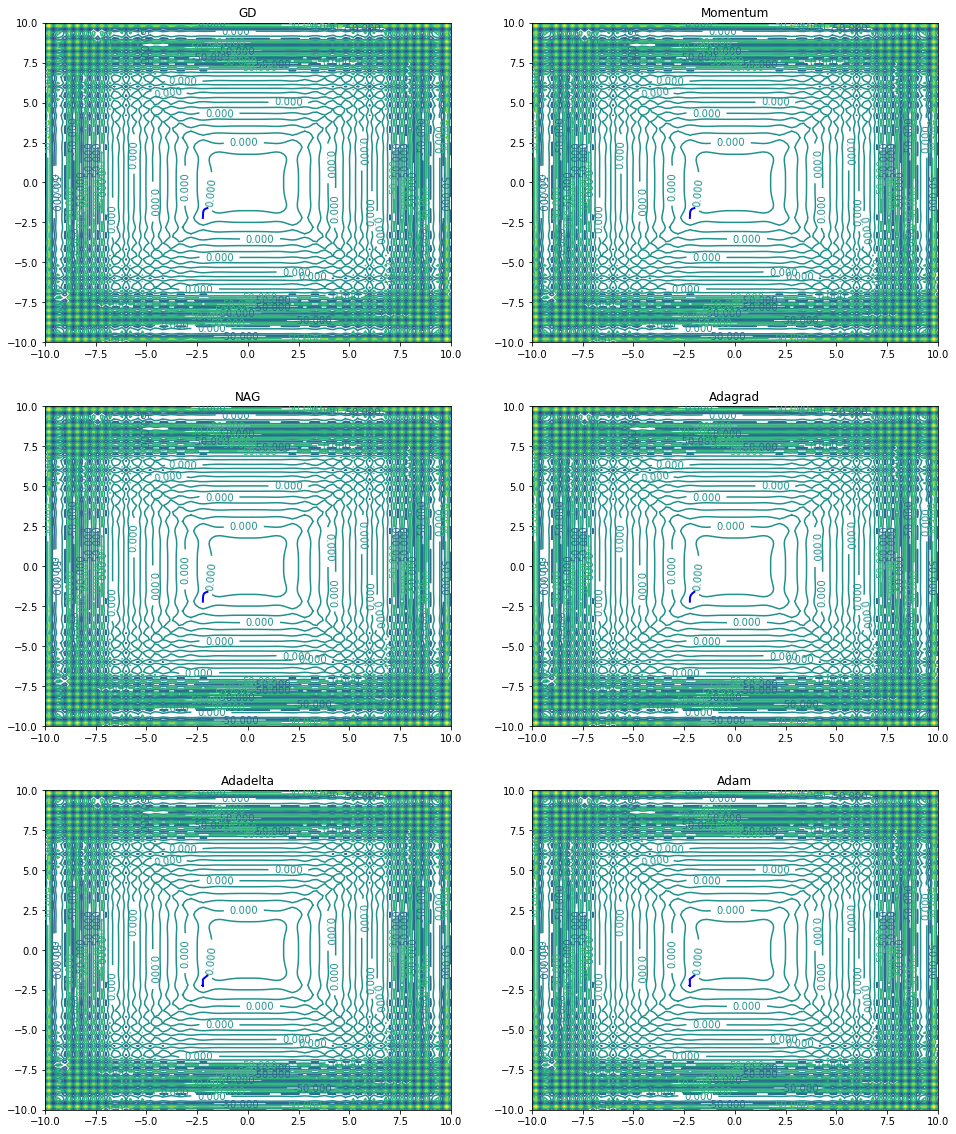

In [32]:
apply_grads(f, df, start_point, Traces)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, NAG и SGD (на MNIST). </i>

In [70]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('.', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [73]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

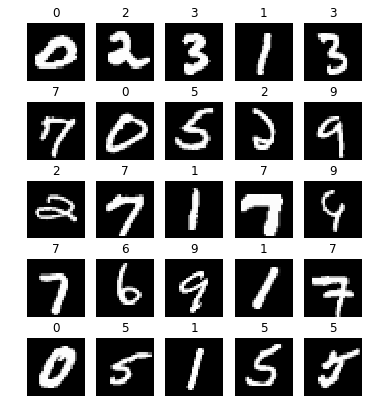

In [74]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [36]:
from torch import optim

In [77]:
D_in, D_mid, D_out = 784, 100, 10
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

In [82]:
def apply_model(model, train_loader, test_loader, loss_fn, optimizer, Epoch):
    losses_train = []
    losses_test = []
    for epoch in xrange(Epoch):
        loss_batch_train = []
        loss_batch_test = []
        for X, y in train_loader:
            X = Variable(X.view(X.size(0), -1))
            y = Variable(y, requires_grad=False)
            optimizer.zero_grad()
            result = model(X)
            loss = loss_fn(result, y)
            loss_batch_train.append(loss.data[0])
            loss.backward()
            optimizer.step()
        for X, y in test_loader:
            X = Variable(X.view(X.size(0), -1))
            y = Variable(y, requires_grad=False)
            optimizer.zero_grad()
            result = model(X)
            loss = loss_fn(result, y)
            loss_batch_test.append(loss.data[0])
            loss.backward()
            optimizer.step()
        losses_train.append(sum(loss_batch_train)/len(loss_batch_train))
        losses_test.append(sum(loss_batch_test)/len(loss_batch_test))
    axis_x = np.arange(1, Epoch + 1)
    axis_y1 = np.array(losses_train)
    axis_y2 = np.array(losses_test)
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(20,8))
        plt.plot(axis_x, axis_y1, linewidth=2.0)
        plt.plot(axis_x, axis_y2, linewidth=2.0)
        plt.xlabel('Epoch')
        plt.ylabel('Cross Entropy Loss')
        plt.legend(['train', 'test'])
        plt.show()
    Scores = []
    for X, y in test_loader:
        X = X.view(X.size(0), -1)
        X = Variable(X)
        y = Variable(y, requires_grad=False)
        result = model(X)
        Scores.append(accuracy_score(y.data.numpy(), np.argmax(result.data.numpy(), axis=1)))
    print("Accuracy: %f" %(sum(Scores)/len(Scores)))
    return      

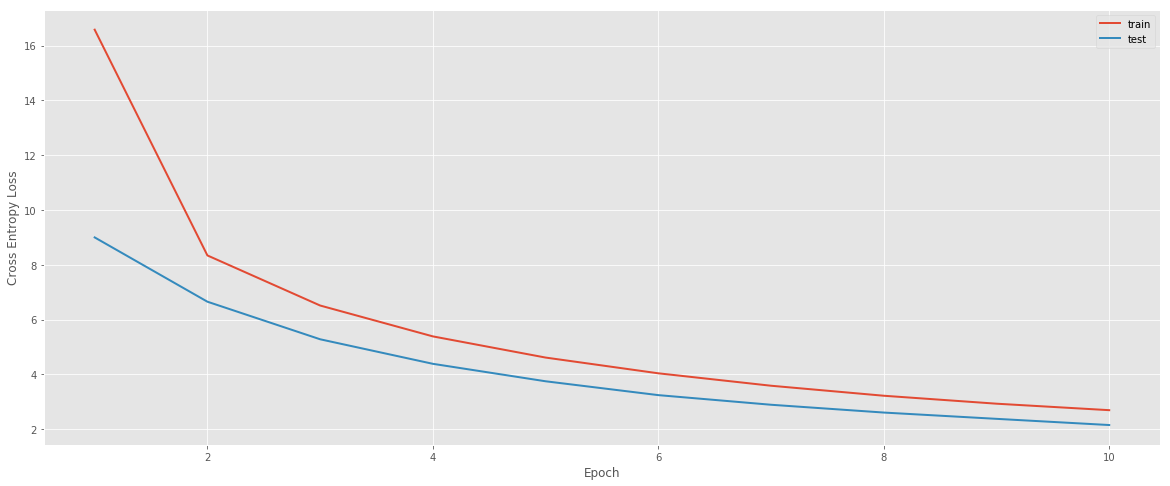

Accuracy: 0.983526


In [103]:
model = nn.Sequential(nn.Linear(D_in, D_mid), nn.ReLU(), nn.Linear(D_mid, D_out))
learning_rate=0.001
optimizer = optim.SGD(model.parameters(), learning_rate)
apply_model(model, train_loader, test_loader, loss_fn, optimizer, Epoch=10)

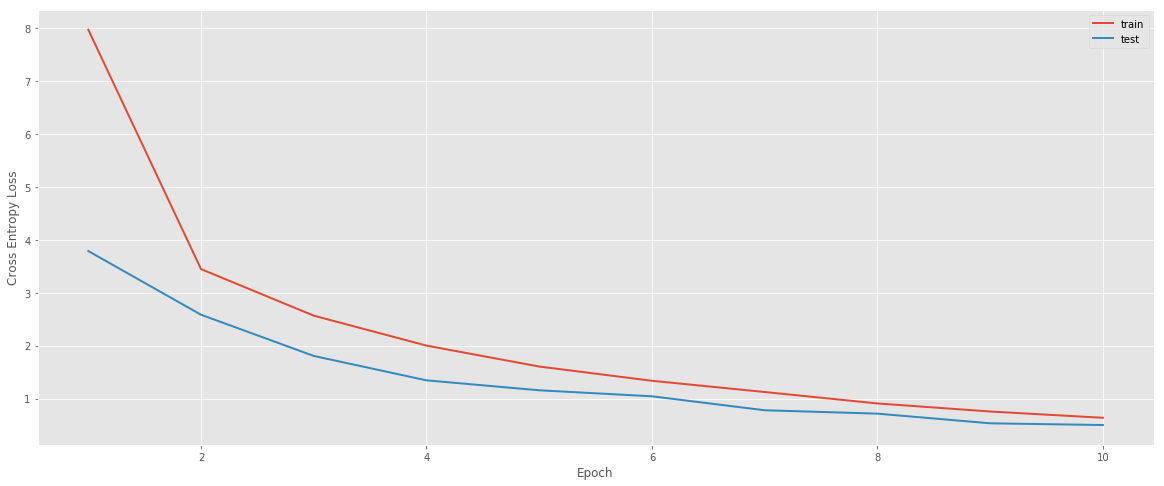

Accuracy: 0.999201


In [104]:
model = nn.Sequential(nn.Linear(D_in, D_mid), nn.ReLU(), nn.Linear(D_mid, D_out))
learning_rate=0.001
optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.9, nesterov=True)
apply_model(model, train_loader, test_loader, loss_fn, optimizer, Epoch=10)

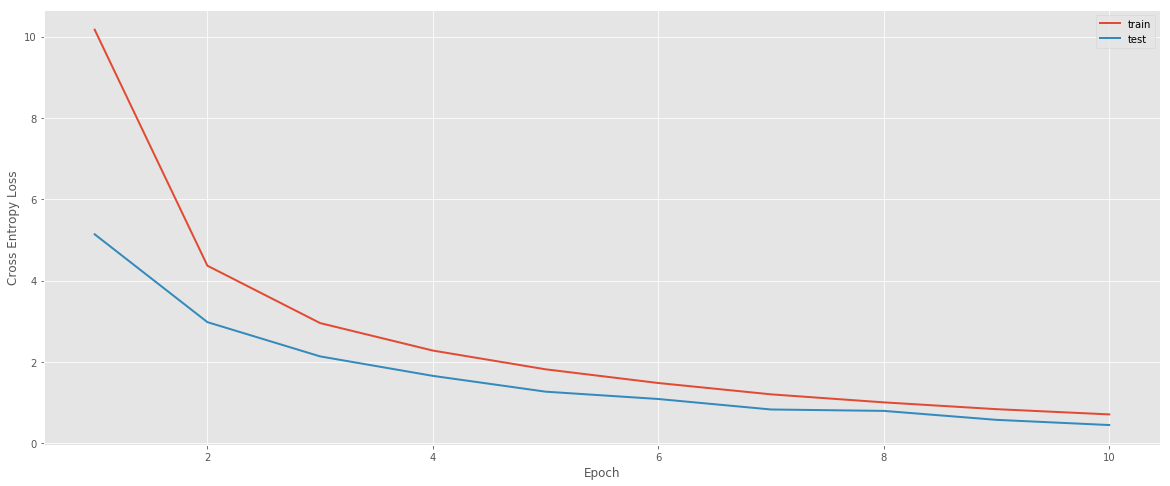

Accuracy: 0.997604


In [105]:
model = nn.Sequential(nn.Linear(D_in, D_mid), nn.ReLU(), nn.Linear(D_mid, D_out))
learning_rate=0.001
optimizer = optim.Adam(model.parameters(), learning_rate)
apply_model(model, train_loader, test_loader, loss_fn, optimizer, Epoch=10)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, NAG и SGD. </i>

In [106]:
def apply_conv_model(model, train_loader, test_loader, loss_fn, optimizer, Epoch):
    losses_train = []
    losses_test = []
    for epoch in xrange(Epoch):
        loss_batch_train = []
        loss_batch_test = []
        for X, y in train_loader:
            X = Variable(X)
            y = Variable(y, requires_grad=False)
            optimizer.zero_grad()
            result = model(X)
            loss = loss_fn(result, y)
            loss_batch_train.append(loss.data[0])
            loss.backward()
            optimizer.step()
        for X, y in test_loader:
            X = Variable(X)
            y = Variable(y, requires_grad=False)
            optimizer.zero_grad()
            result = model(X)
            loss = loss_fn(result, y)
            loss_batch_test.append(loss.data[0])
            loss.backward()
            optimizer.step()
        losses_train.append(sum(loss_batch_train)/len(loss_batch_train))
        losses_test.append(sum(loss_batch_test)/len(loss_batch_test))
    axis_x = np.arange(1, Epoch + 1)
    axis_y1 = np.array(losses_train)
    axis_y2 = np.array(losses_test)
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(20,8))
        plt.plot(axis_x, axis_y1, linewidth=2.0)
        plt.plot(axis_x, axis_y2, linewidth=2.0)
        plt.xlabel('Epoch')
        plt.ylabel('Cross Entropy Loss')
        plt.legend(['train', 'test'])
        plt.show()
    Scores = []
    for X, y in test_loader:
        X = Variable(X)
        y = Variable(y, requires_grad=False)
        result = model(X)
        Scores.append(accuracy_score(y.data.numpy(), np.argmax(result.data.numpy(), axis=1)))
    print("Accuracy: %f" %(sum(Scores)/len(Scores)))
    return      

In [107]:
class ConvNet(torch.nn.Module):
    def __init__(self, image_size, channels):
        super(ConvNet, self).__init__()
        self.conv_layers = torch.nn.Sequential(torch.nn.Conv2d(channels, 8, 3, padding=1), 
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(2),
                                         torch.nn.Conv2d(8, 16, 3, padding=1))
        self.linear_layers = torch.nn.Sequential(torch.nn.Linear(image_size/2*image_size/2*16, 10))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

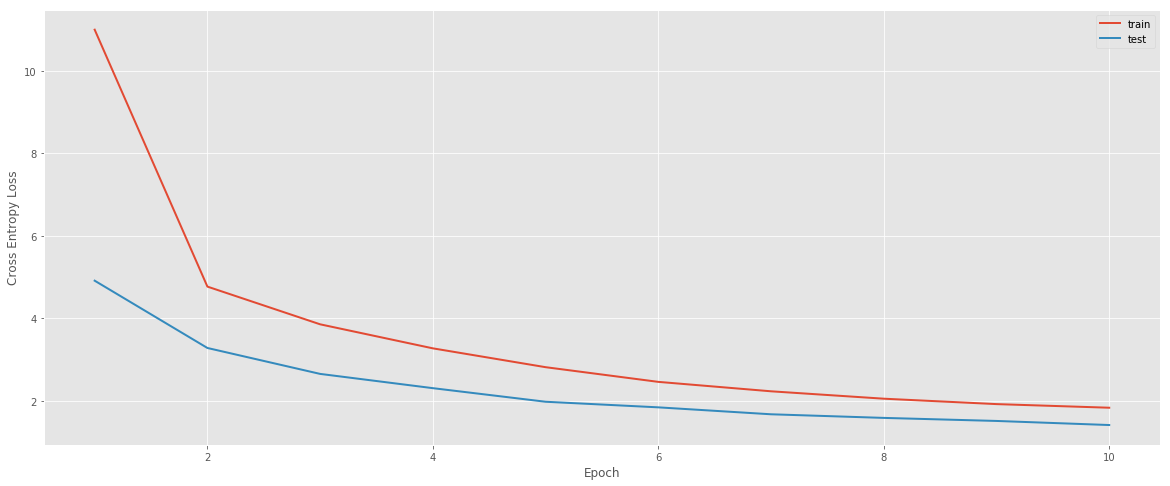

Accuracy: 0.989117


In [108]:
model = ConvNet(28, 1)
learning_rate=0.001
optimizer = optim.SGD(model.parameters(), learning_rate)
apply_conv_model(model, train_loader, test_loader, loss_fn, optimizer, Epoch=10)

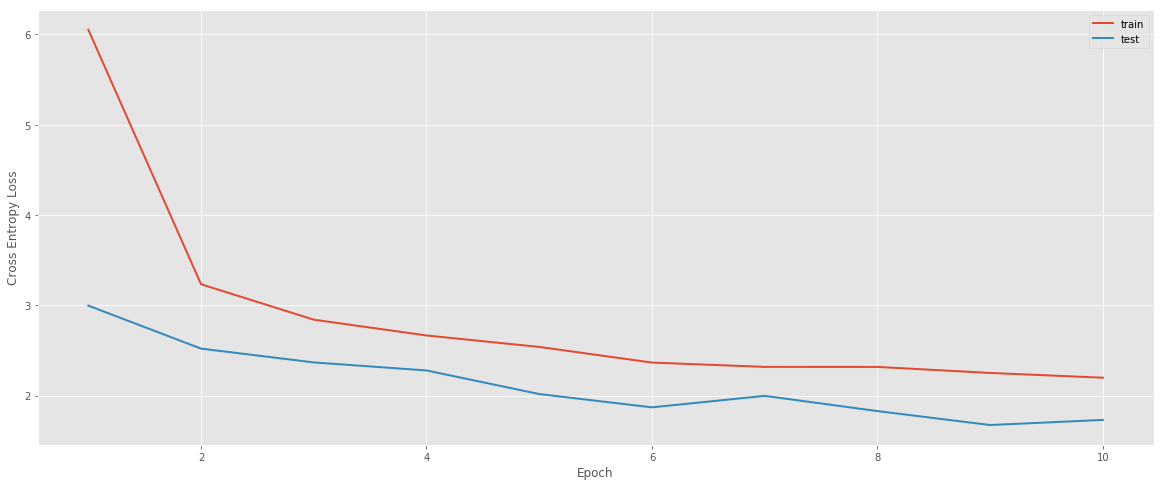

Accuracy: 0.986022


In [109]:
model = ConvNet(28, 1)
learning_rate=0.001
optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.9, nesterov=True)
apply_conv_model(model, train_loader, test_loader, loss_fn, optimizer, Epoch=10)

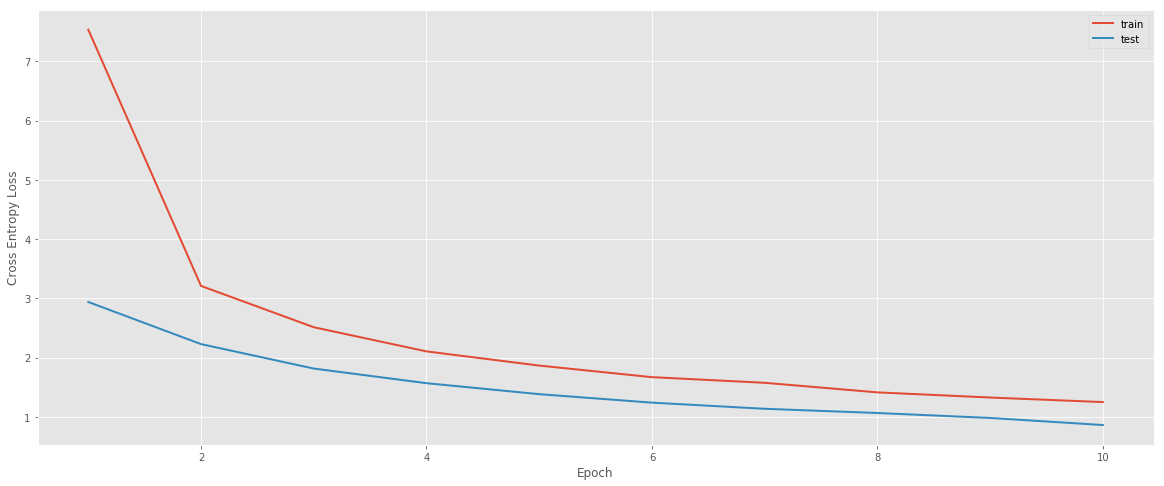

Accuracy: 0.995907


In [110]:
model = ConvNet(28, 1)
learning_rate=0.001
optimizer = optim.Adam(model.parameters(), learning_rate)
apply_conv_model(model, train_loader, test_loader, loss_fn, optimizer, Epoch=10)

При одинаковом learning_rate = 0.001 Adam и NAG сходятся быстрее, чем SGD.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: